# Change in SSB and Planets
From here, 

* ``_sol`` = something with respect to the Sun (solar-centric)

In [1]:
# Import modules
import datetime
import spiceypy as sp
import numpy as np
from matplotlib import pyplot as plt

# Load the SPICE kernels via a meta file
sp.furnsh('kernel_meta.txt')

T1_UTC = datetime.datetime(year=2000, month=1, day=1, hour=0, minute=0, second=0)
DDAYS = 10000
T2_UTC = T1_UTC + datetime.timedelta(days=DDAYS)

# Convert the datetime objects now to strings
T1_UTC_STR = T1_UTC.strftime('%Y-%m-%dT%H:%M:%S')
T2_UTC_STR = T2_UTC.strftime('%Y-%m-%dT%H:%M:%S')

print(f"Init time in UTC: {T1_UTC_STR:s}")
print(f"End time in UTC: {T2_UTC_STR:s}\n")

T1_ET = sp.utc2et(T1_UTC_STR)
T2_ET = sp.utc2et(T2_UTC_STR)

times_et = np.linspace(T1_ET, T2_ET, DDAYS)

Init time in UTC: 2000-01-01T00:00:00
End time in UTC: 2027-05-19T00:00:00



In [2]:
# Get R_SUN
_, R_SUN = sp.bodvcd(bodyid=10, item='RADII', maxn=3)
print(R_SUN)

R_SUN = R_SUN[0]

[696000. 696000. 696000.]


In [3]:
times_utc = np.array([sp.et2datetime(_t).date() for _t in times_et])
ssb_pos_sol = np.array([sp.spkgps(targ=0, et=_t, ref='ECLIPJ2000', obs=10)[0] for _t in times_et])
ssb_pos_sol_scaled = ssb_pos_sol/R_SUN
ssb_dist_sol_scaled = np.linalg.norm(ssb_pos_sol_scaled, axis=1)

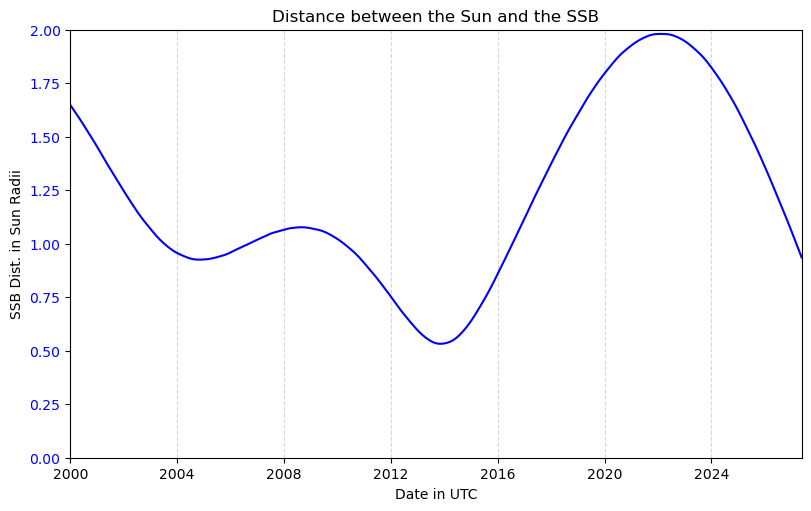

In [4]:
# Import the matplotlib library

# Set a figure
fig, axs = plt.subplots(1, 1, figsize=(8, 5), layout="constrained", gridspec_kw=None, sharex=False, sharey=False)
ax = axs

# Plot the distance between the Sun and the SSB
ax.plot(times_utc, ssb_dist_sol_scaled, "b-")
ax.set(
    xlabel="Date in UTC",
    ylabel="SSB Dist. in Sun Radii",
    title="Distance between the Sun and the SSB",
    xlim=(min(times_utc), max(times_utc)),
    ylim=(0, 2)
)
ax.tick_params(axis='y', labelcolor='b')
ax.grid(axis='x', linestyle='dashed', alpha=0.5)

plt.savefig('SSB2SUN_DISTANCE.png', dpi=300)

In [5]:
sp.vsep?

Signature: sp.vsep(v1: numpy.ndarray, v2: numpy.ndarray) -> float
Docstring:
Find the separation angle in radians between two double
precision, 3-dimensional vectors. This angle is defined as zero
if either vector is zero.

https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/cspice/vsep_c.html

:param v1: First vector
:param v2: Second vector
:return: separation angle in radians
File:      ~/mambaforge/envs/spherex/lib/python3.11/site-packages/spiceypy/spiceypy.py
Type:      function

In [7]:
# Additionally, we want to compute the position vector of all outer gas
# giants. We define a dictionary with a planet's barycentre abbreviation and
# corresponding NAIF ID code
NAIF_ID = {
    'JUP': 5,
    'SAT': 6,
    'URA': 7,
    'NEP': 8
}
eph = dict()

for naif, key in NAIF_ID.items():
    # Compute the planet's position as seen from the Sun.
    _pos = np.array([sp.spkgps(targ=key, et=_t, ref='ECLIPJ2000', obs=10)[0] for _t in times_et])
    eph[naif] = dict(
        pos_sol=_pos,
        alpha=np.rad2deg([sp.vsep(__pos, _ssb_pos_sol) for (__pos, _ssb_pos_sol) in zip(_pos, ssb_pos_sol)])
    )
    # alpha = SSB-Sun-Planet angle

In [16]:
# Let's verify the function vsep and compute the phase angle between the SSB
# and Jupiter as seen from the Sun (we use the very first array entries).
def np_vsep(v1, v2):
      return np.rad2deg(np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))))

print('Phase angle between the SSB and Jupiter as seen from the Sun (first array entry): ')
print("np: ", np_vsep(ssb_pos_sol[0], eph['JUP']['pos_sol'][0]))
print("sp: ", np.rad2deg(sp.vsep(ssb_pos_sol[0], eph['JUP']['pos_sol'][0])))

Phase angle between the SSB and Jupiter as seen from the Sun (first array entry): 
np:  14.88953374168662
sp:  14.889533741686588


Text(0.5, 0, 'Date in UTC')

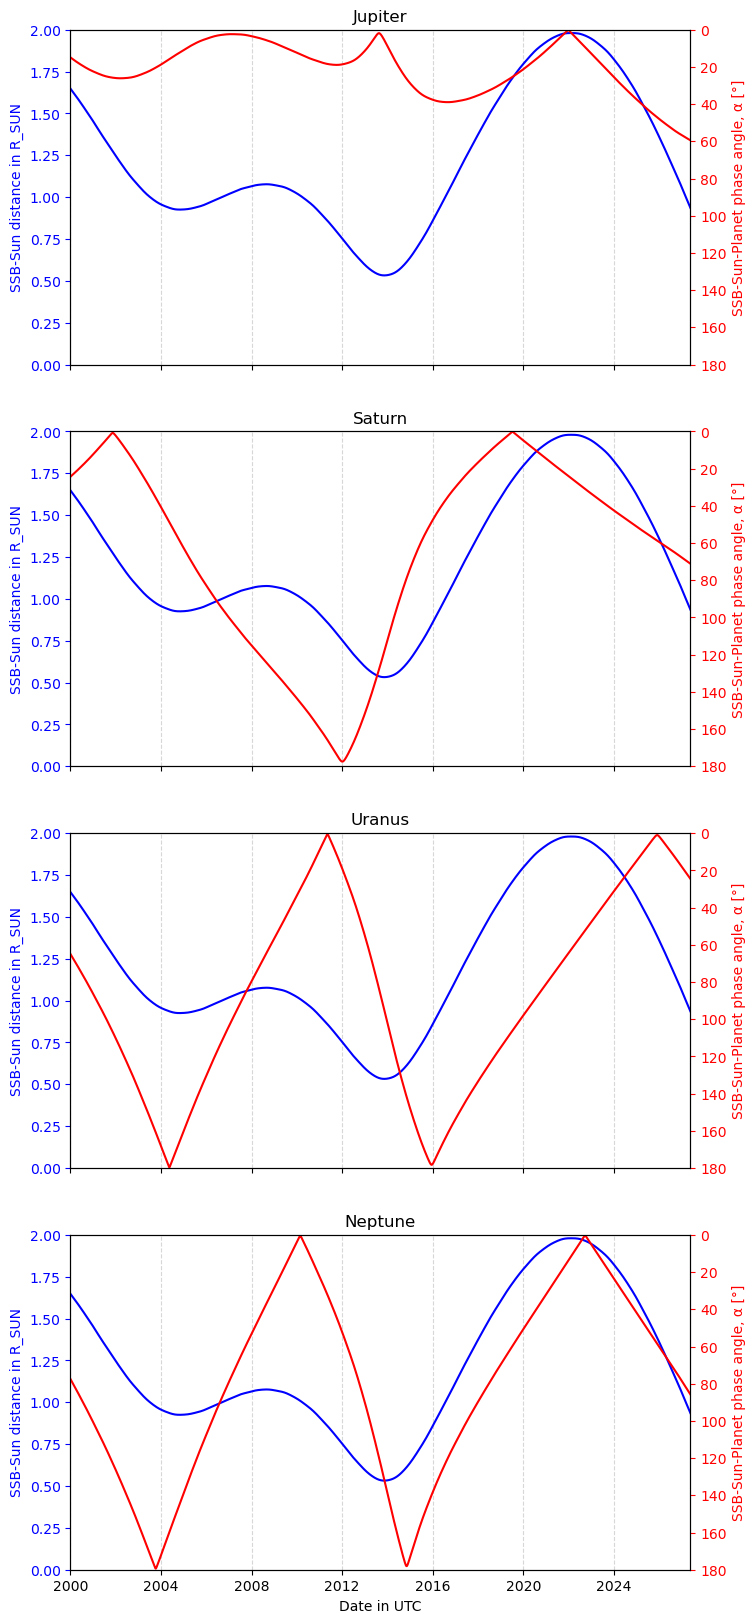

In [34]:
# Create a 4 axes plot where all 4 plots are vertically aligned and share the
# x axis (date in UTC)
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8, 20))

# We iterate through the planets (from Jupiter to Neptune) and plot the
# phase angle between the planet and the SSB, as seen from the Sun, in each
# axis individually
for _ax, _nam, fullname in zip(axs, NAIF_ID.keys(), ['Jupiter', 'Saturn', 'Uranus', 'Neptune']):
    _ax.plot(times_utc, ssb_dist_sol_scaled, "b-")
    _ax.set(
        title=fullname,
        xlim=(min(times_utc), max(times_utc)),
        ylim=(0, 2),
    )
    _ax.tick_params(axis='y', labelcolor='b')

    # We add now the phase angle values and copy the x axis for this purpose
    _ax2 = _ax.twinx()
    _ax2.plot(times_utc, eph[_nam]['alpha'], "r-")
    _ax2.set(
        ylim=(180, 0),  # invert so that large r_ssb corresponds to small α is clearly visible.
    )

    for ax, lab, color in zip([_ax, _ax2], ["SSB-Sun distance in R_SUN", "SSB-Sun-Planet phase angle, α [°]"], ['b', 'r']):
        ax.set_ylabel(lab, color=color)
        ax.tick_params(axis='y', which='both', color=color, labelcolor=color)

    _ax.grid(axis='x', linestyle='dashed', alpha=0.5)


# Finally we set the x label ...
axs[-1].set_xlabel('Date in UTC')

When SSB-Sun-Jupiter is at the opposition/conjunction, the SSB-Sun distance is nearly min/max.